### Testing the Environment

In [1]:
# Testing the environment
import cv2
import numpy as np
import tensorflow as tf

print("OpenCV version", cv2.__version__)

print("Numpy version", np.__version__)

print("Tensorflow version", tf.__version__)


OpenCV version 3.2.0-dev
Numpy version 1.13.1
Tensorflow version 1.3.0


#### Adobe Panorama Dataset

https://sourceforge.net/adobe/adobedatasets/panoramas/home/Home/

### Matching

In [2]:
import cv2
import numpy as np 

class matchers:
	def __init__(self):
		self.surf = cv2.xfeatures2d.SURF_create()
		FLANN_INDEX_KDTREE = 0
		index_params = dict(algorithm=0, trees=5)
		search_params = dict(checks=50)
		self.flann = cv2.FlannBasedMatcher(index_params, search_params)

	def match(self, i1, i2, direction=None):
		imageSet1 = self.getSURFFeatures(i1)
		imageSet2 = self.getSURFFeatures(i2)
		print("Direction : ", direction)
		matches = self.flann.knnMatch(
			imageSet2['des'],
			imageSet1['des'],
			k=2
			)
		good = []
		for i , (m, n) in enumerate(matches):
			if m.distance < 0.7*n.distance:
				good.append((m.trainIdx, m.queryIdx))

		if len(good) > 4:
			pointsCurrent = imageSet2['kp']
			pointsPrevious = imageSet1['kp']

			matchedPointsCurrent = np.float32(
				[pointsCurrent[i].pt for (__, i) in good]
			)
			matchedPointsPrev = np.float32(
				[pointsPrevious[i].pt for (i, __) in good]
				)

			H, s = cv2.findHomography(matchedPointsCurrent, matchedPointsPrev, cv2.RANSAC, 4)
			return H
		return None

	def getSURFFeatures(self, im):
		gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
		kp, des = self.surf.detectAndCompute(gray, None)
		return {'kp':kp, 'des':des}


### Before Stitching

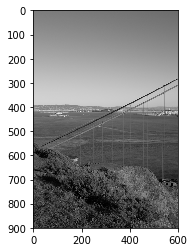

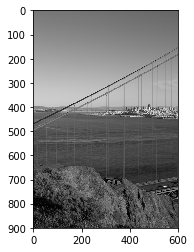

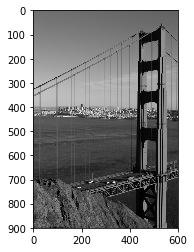

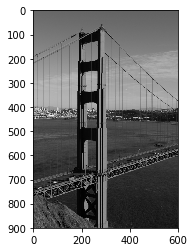

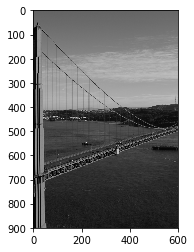

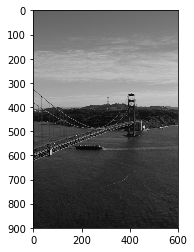

In [26]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

IMG_PATH = os.path.join("..","images","Panorama","goldengate","data.txt")

fp = open(IMG_PATH, 'r')

filenames = [os.path.join("..","images","Panorama",each.strip()) for each in  fp.readlines()]

for image in filenames:
    im = cv2.imread(image)
    plt.imshow(im)
    plt.show()

### After Stitching

['../images/Panorama/goldengate/goldengate-00.png', '../images/Panorama/goldengate/goldengate-01.png', '../images/Panorama/goldengate/goldengate-02.png', '../images/Panorama/goldengate/goldengate-03.png', '../images/Panorama/goldengate/goldengate-04.png', '../images/Panorama/goldengate/goldengate-05.png']
[(320, 480, 3), (320, 480, 3), (320, 480, 3), (320, 480, 3), (320, 480, 3), (320, 480, 3)]
Number of images : 6
Center index image : 3
Image lists prepared
Direction :  left
Homography is :  [[  9.32722968e-01  -1.28509319e-03   1.88615581e+02]
 [ -1.85251010e-02   9.88056314e-01   1.95423595e+00]
 [ -1.42271281e-04   2.46736573e-05   1.00000000e+00]]
Inverse Homography : [[  1.04226612e+00   6.26507504e-03  -1.96599872e+02]
 [  1.92491359e-02   1.01225316e+00  -5.60886846e+00]
 [  1.47809589e-04  -2.40846473e-05   9.72167876e-01]]
final ds=> [ 295.23847332  316.34996868    1.        ]
image dsize => (709, 338)
Direction :  left
Homography is :  [[  8.82536824e-01   3.74753296e-03   4

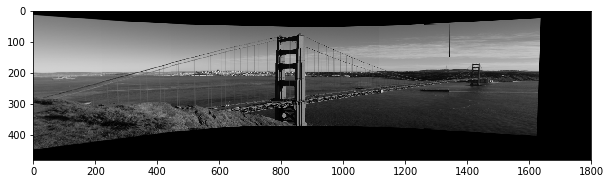

In [22]:
import os
import time
import matplotlib.pyplot as plt

%matplotlib inline

class Stitch:
	def __init__(self, args):
		self.path = args
		fp = open(self.path, 'r')
		
		#filenames = [ os.path.join("data",line.split()[2] + ".jpg") for line in  fp.readlines()][:6]
		
		filenames = [os.path.join("..","images","Panorama",each.strip()) for each in  fp.readlines()]

		print(filenames)
		self.images = [cv2.resize(cv2.imread(each),(480, 320)) for each in filenames]
		print([x.shape for x in self.images])
		self.count = len(self.images)
		self.left_list, self.right_list, self.center_im = [], [],None
		self.matcher_obj = matchers()
		self.prepare_lists()

	def prepare_lists(self):
		
		print("Number of images : %d"%self.count)
		self.centerIdx = int(self.count/2) 
		
		print("Center index image : {0}".format(self.centerIdx))
		self.center_im = self.images[self.centerIdx]
		for i in range(self.count):
			if(i<=self.centerIdx):
				self.left_list.append(self.images[i])
			else:
				self.right_list.append(self.images[i])
		print("Image lists prepared")

	def leftshift(self):
		a = self.left_list[0]
		for b in self.left_list[1:]:
			H = self.matcher_obj.match(a, b, 'left')
			print("Homography is : ", H)
			xh = np.linalg.inv(H)
			print("Inverse Homography :", xh)
			ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]));
			ds = ds/ds[-1]
			print("final ds=>", ds)
			f1 = np.dot(xh, np.array([0,0,1]))
			f1 = f1/f1[-1]
			xh[0][-1] += abs(f1[0])
			xh[1][-1] += abs(f1[1])
			ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]))
			offsety = abs(int(f1[1]))
			offsetx = abs(int(f1[0]))
			dsize = (int(ds[0])+offsetx, int(ds[1]) + offsety)
			print("image dsize =>", dsize)
			tmp = cv2.warpPerspective(a, xh, dsize)
			tmp[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b
			a = tmp

		self.leftImage = tmp

		
	def rightshift(self):
		for each in self.right_list:
			H = self.matcher_obj.match(self.leftImage, each, 'right')
			print("Homography :", H)
			txyz = np.dot(H, np.array([each.shape[1], each.shape[0], 1]))
			txyz = txyz/txyz[-1]
			dsize = (int(txyz[0])+self.leftImage.shape[1], int(txyz[1])+self.leftImage.shape[0])
			tmp = cv2.warpPerspective(each, H, dsize)
			tmp = self.mix_and_match(self.leftImage, tmp)
			print("tmp shape",tmp.shape)
			print("self.leftimage shape=", self.leftImage.shape)
			self.leftImage = tmp
		


	def mix_and_match(self, leftImage, warpedImage):
		i1y, i1x = leftImage.shape[:2]
		i2y, i2x = warpedImage.shape[:2]
		print(leftImage[-1,-1])

		t = time.time()
		black_l = np.where(leftImage == np.array([0,0,0]))
		black_wi = np.where(warpedImage == np.array([0,0,0]))
		print(time.time() - t)
		print(black_l[-1])

		for i in range(0, i1x):
			for j in range(0, i1y):
				try:
					if(np.array_equal(leftImage[j,i],np.array([0,0,0])) and  np.array_equal(warpedImage[j,i],np.array([0,0,0]))):
						# print "BLACK"
						# instead of just putting it with black, 
						# take average of all nearby values and avg it.
						warpedImage[j,i] = [0, 0, 0]
					else:
						if(np.array_equal(warpedImage[j,i],[0,0,0])):
							# print "PIXEL"
							warpedImage[j,i] = leftImage[j,i]
						else:
							if not np.array_equal(leftImage[j,i], [0,0,0]):
								bw, gw, rw = warpedImage[j,i]
								bl,gl,rl = leftImage[j,i]
								# b = (bl+bw)/2
								# g = (gl+gw)/2
								# r = (rl+rw)/2
								warpedImage[j, i] = [bl,gl,rl]
				except:
					pass
		# cv2.imshow("waRPED mix", warpedImage)
		# cv2.waitKey()
		return warpedImage
    
IMG_PATH = os.path.join("..","images","Panorama","goldengate","data.txt")

s = Stitch(IMG_PATH)
s.leftshift()
s.rightshift()
print("done")

fig = plt.figure("Panorama", (10,10))

out_img = s.leftImage

out_img = out_img[0:480,200:2000,:]
plt.imshow(out_img)

plt.show()

